In [1]:
import sys
sys.path.append("./ml/")
import glob
import json
import struct
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
import train_nnue

In [3]:
model = train_nnue.Nnue()
model.load_state_dict(torch.load("nnue.pt"))
model.adjust_leak(0)

In [4]:
data_files = glob.glob("./run-011-duck-chess/step-*/games/*.npz")[-5:]
data_files

['./run-011-duck-chess/step-101/games/games-mcts-88652de431071378-nnue-data.npz',
 './run-011-duck-chess/step-075/games/games-mcts-fb530bceb09373bc-nnue-data.npz',
 './run-011-duck-chess/step-075/games/games-mcts-86bf3b09ec0916c0-nnue-data.npz',
 './run-011-duck-chess/step-103/games/games-mcts-eb86a507f6c85730-nnue-data.npz',
 './run-011-duck-chess/step-103/games/games-mcts-63029b2183c92bcd-nnue-data.npz']

In [5]:
make_batch = train_nnue.get_make_batch(data_files, "cpu")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.48it/s]

Total examples: 3785384
Constant model loss: 0.6828318840027551


In [6]:
indices, offsets, which_model, lengths, targets = make_batch(1024 * 1024)

In [7]:
def estimate_loss():
    outputs = model(indices, offsets, which_model, lengths)
    return torch.mean((outputs - targets)**2)

In [8]:
estimate_loss()

tensor(0.4002, grad_fn=<MeanBackward0>)

In [9]:
all_interm = []

def hook(comp, inp, out):
    all_interm.append((comp, tuple(x.clone() for x in inp), out.clone()))
    overall_min = float("inf")
    overall_max = -float("inf")
    for thing in inp:
        overall_min = min(overall_min, thing.min().item())
        overall_max = max(overall_max, thing.max().item())
    first = inp[0]
    print(f"{comp.__class__.__name__:30} inp range: {overall_min:.3f} . {first.float().var()**0.5:.3f} . {overall_max:.3f}  out range: {out.min().item():.3f} . {out.var()**0.5:.3f} . {out.max().item():.3f}")
    #print("GOT:", comp) #inp, out)
    #if isinstance(comp, train_nnue.AnnealedLeakyClippedRelu):   
    #    print(

if "module_to_handle" in globals():
    for handle in module_to_handle.values():
        handle.remove()

module_to_handle = {}
def apply_hooks(m):
    if m in module_to_handle:
        return
    module_to_handle[m] = m.register_forward_hook(hook)
    for k, v in m._modules.items():
        apply_hooks(v)

apply_hooks(model)

In [10]:
outputs = model(indices, offsets, which_model, lengths)
lose = outputs[targets == -1]
draw = outputs[targets == 0]
win = outputs[targets == 1]

EmbeddingBag                   inp range: 0.000 . 8971.383 . 40134190.000  out range: -5.122 . 0.523 . 3.544
AnnealedLeakyClippedRelu       inp range: -5.089 . 0.501 . 3.011  out range: 0.000 . 0.114 . 0.996
Linear                         inp range: 0.000 . 0.114 . 0.996  out range: -10.462 . 0.461 . 8.213
AnnealedLeakyClippedRelu       inp range: -10.462 . 0.461 . 8.213  out range: 0.000 . 0.214 . 0.996
Linear                         inp range: 0.000 . 0.214 . 0.996  out range: -1.295 . 0.234 . 1.939
AnnealedLeakyClippedRelu       inp range: -1.295 . 0.234 . 1.939  out range: 0.000 . 0.175 . 0.996
Linear                         inp range: 0.000 . 0.175 . 0.996  out range: -3.988 . 0.726 . 3.092
Sequential                     inp range: 0.000 . 0.114 . 0.996  out range: -3.988 . 0.726 . 3.092
Tanh                           inp range: -4.226 . 0.834 . 4.260  out range: -1.000 . 0.501 . 1.000
Nnue                           inp range: 0.000 . 8971.383 . 40134190.000  out range: -1.000 . 0

In [11]:
# Each clipped relu wants inputs from -128 to +127 for its active range.
# If the largest intermediates we care to represent are -2.0 to +2.0,
# then this means that -2.0 should map to -32768, and +1.99... should map to +32767.
# Therefore we scale down inputs by 128 before passing them in to the clipped relu.
# Therefore, 128 * 128 = 1684 represents 1.0 as an input to relu.
# This means that a quantized weight of 128 represents the weight 1.0 in the original.
# There is one exception to this, in the original embedding layer, and all biases,
# where 16384 represents 1.0.

In [12]:
new_values = {}
quantized_weights = {}
output_right_shift = {}
for k, v in model.named_parameters():
    output_right_shift[k] = 0
    if "main_embed" in k or k == "main_bias":
        quantized = torch.round(v * 2048).to(torch.int16)
        f = quantized.float().detach() / 2048
        output_right_shift[k] = 11
    elif "bias" in k:
        quantized = torch.round(v * 16384).to(torch.int16)
        f = quantized.float().detach() / 16384
        output_right_shift[k] = 14
    else:
        quantized = torch.round(v * 128).to(torch.int8)
        f = quantized.float().detach() / 128
        output_right_shift[k] = 7
    zero_fraction = (quantized == 0).sum() / v.numel()
    new_values[k] = f
    quantized_weights[k] = quantized
    print(f"{k:20} {str(tuple(v.shape)):15} {v.min().item():.3f} {v.max().item():.3f} zero={100 * zero_fraction:.3f}%")

main_bias            (256,)          -0.605 0.285 zero=0.391%
main_embed.weight    (106496, 256)   -0.446 0.494 zero=0.607%
main_net.0.weight    (16, 256)       -0.460 0.745 zero=3.052%
main_net.0.bias      (16,)           -0.197 0.185 zero=0.000%
main_net.2.weight    (32, 16)        -0.479 0.545 zero=0.977%
main_net.2.bias      (32,)           -0.172 0.234 zero=0.000%
main_net.4.weight    (1, 32)         -0.584 0.431 zero=0.000%
main_net.4.bias      (1,)            0.040 0.040 zero=0.000%


In [13]:
model.load_state_dict(new_values)

<All keys matched successfully>

In [14]:
estimate_loss()

EmbeddingBag                   inp range: 0.000 . 8971.383 . 40134190.000  out range: -5.123 . 0.523 . 3.545
AnnealedLeakyClippedRelu       inp range: -5.089 . 0.501 . 3.011  out range: 0.000 . 0.114 . 0.996
Linear                         inp range: 0.000 . 0.114 . 0.996  out range: -10.488 . 0.461 . 8.228
AnnealedLeakyClippedRelu       inp range: -10.488 . 0.461 . 8.228  out range: 0.000 . 0.214 . 0.996
Linear                         inp range: 0.000 . 0.214 . 0.996  out range: -1.293 . 0.234 . 1.943
AnnealedLeakyClippedRelu       inp range: -1.293 . 0.234 . 1.943  out range: 0.000 . 0.175 . 0.996
Linear                         inp range: 0.000 . 0.175 . 0.996  out range: -3.993 . 0.722 . 3.069
Sequential                     inp range: 0.000 . 0.114 . 0.996  out range: -3.993 . 0.722 . 3.069
Tanh                           inp range: -4.241 . 0.829 . 4.254  out range: -1.000 . 0.500 . 1.000
Nnue                           inp range: 0.000 . 8971.383 . 40134190.000  out range: -1.000 . 0

tensor(0.4003, grad_fn=<MeanBackward0>)

In [15]:
def pack_i32(i32):
    return struct.pack("<i", i32)

In [16]:
header_alloc = 768 #7808
aligned_storage = bytearray(header_alloc)

def add_bytes(b):
    # Align to the nearest 32-byte boundary.
    padding = (32 - len(aligned_storage)) % 32
    aligned_storage.extend(b'\0' * padding)
    offset = len(aligned_storage)
    aligned_storage.extend(b)
    return offset

weights = {}
for k, v in quantized_weights.items():
    shift = output_right_shift[k]
    v = v.detach().cpu().numpy()
    k = k.replace("networks.", "n")
    k = k.replace("0.weight", "0.w")
    k = k.replace("2.weight", "1.w")
    k = k.replace("4.weight", "2.w")
    k = k.replace("0.bias", "0.b")
    k = k.replace("2.bias", "1.b")
    k = k.replace("4.bias", "2.b")
    k = k.replace("main_net.", "n0.")
    offset = add_bytes(v.tobytes())
    assert offset % 32 == 0
    weights[k] = {
        "shape": tuple(v.shape),
        "dtype": {"int8": "i8", "int16": "i16"}[str(v.dtype)],
        "offset": offset,
        "shift": shift,
    }
message = {
    "version": "v1",
    "weights": weights,
}

message_bytes = json.dumps(message).encode()
assert len(message_bytes) < header_alloc
aligned_storage[:len(message_bytes)] = message_bytes
len(message_bytes)

658

In [17]:
with open("src/nnue-data.bin", "wb") as f:
    f.write(aligned_storage)

In [18]:
message

{'version': 'v1',
 'weights': {'main_bias': {'shape': (256,),
   'dtype': 'i16',
   'offset': 768,
   'shift': 11},
  'main_embed.weight': {'shape': (106496, 256),
   'dtype': 'i16',
   'offset': 1280,
   'shift': 11},
  'n0.0.w': {'shape': (16, 256),
   'dtype': 'i8',
   'offset': 54527232,
   'shift': 7},
  'n0.0.b': {'shape': (16,), 'dtype': 'i16', 'offset': 54531328, 'shift': 14},
  'n0.1.w': {'shape': (32, 16), 'dtype': 'i8', 'offset': 54531360, 'shift': 7},
  'n0.1.b': {'shape': (32,), 'dtype': 'i16', 'offset': 54531872, 'shift': 14},
  'n0.2.w': {'shape': (1, 32), 'dtype': 'i8', 'offset': 54531936, 'shift': 7},
  'n0.2.b': {'shape': (1,), 'dtype': 'i16', 'offset': 54531968, 'shift': 14}}}

# Debug network eval

In [71]:
moves = [
    {"from":12,"to":28},
    {"from":16,"to":16},
    {"from":52,"to":36},
    {"from":16,"to":24},
    {"from":3,"to":39},
    {"from":24,"to":16},
    {"from":54,"to":46},
    {"from":16,"to":24},
    {"from":4,"to":12},
    {"from":24,"to":16},
    #{"from":46,"to":39},
]

In [72]:
import engine

In [73]:
e = engine.Engine(0)
for m in moves:
    print(e.apply_move(json.dumps(m)))
feat_indices = e.get_nnue_feature_indices()

None
None
None
None
None
None
None
None
None
None


In [74]:
all_interm.clear()

In [75]:
out = model(
    torch.LongTensor(feat_indices),
    torch.LongTensor([0]), # offset = 0
    torch.LongTensor([1]), # which_model = 1 (white, non-duck turn)
    torch.LongTensor([len(feat_indices)]),
)

EmbeddingBag                   inp range: 0.000 . 6710.563 . 64016.000  out range: -3.067 . 0.809 . 2.175
AnnealedLeakyClippedRelu       inp range: -2.837 . 0.747 . 1.621  out range: 0.000 . 0.149 . 0.996
Linear                         inp range: 0.000 . 0.149 . 0.996  out range: -0.692 . 0.366 . 0.483
AnnealedLeakyClippedRelu       inp range: -0.692 . 0.366 . 0.483  out range: 0.000 . 0.154 . 0.483
Linear                         inp range: 0.000 . 0.154 . 0.483  out range: -0.213 . 0.186 . 0.552
AnnealedLeakyClippedRelu       inp range: -0.213 . 0.186 . 0.552  out range: 0.000 . 0.145 . 0.552
Linear                         inp range: 0.000 . 0.145 . 0.552  out range: -0.538 . nan . -0.538
Sequential                     inp range: 0.000 . 0.149 . 0.996  out range: -0.538 . nan . -0.538
Tanh                           inp range: -0.257 . nan . -0.257  out range: -0.251 . nan . -0.251
Nnue                           inp range: 0.000 . 6710.563 . 64016.000  out range: -0.251 . nan . -0.251


In [76]:
len(all_interm)

10

In [77]:
for i, (k, _, _) in enumerate(all_interm): print(i, "->", k)

0 -> EmbeddingBag(106496, 256, mode=sum)
1 -> AnnealedLeakyClippedRelu()
2 -> Linear(in_features=256, out_features=16, bias=True)
3 -> AnnealedLeakyClippedRelu()
4 -> Linear(in_features=16, out_features=32, bias=True)
5 -> AnnealedLeakyClippedRelu()
6 -> Linear(in_features=32, out_features=1, bias=True)
7 -> Sequential(
  (0): Linear(in_features=256, out_features=16, bias=True)
  (1): AnnealedLeakyClippedRelu()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): AnnealedLeakyClippedRelu()
  (4): Linear(in_features=32, out_features=1, bias=True)
)
8 -> Tanh()
9 -> Nnue(
  (main_embed): EmbeddingBag(106496, 256, mode=sum)
  (clipped_relu): AnnealedLeakyClippedRelu()
  (tanh): Tanh()
  (main_net): Sequential(
    (0): Linear(in_features=256, out_features=16, bias=True)
    (1): AnnealedLeakyClippedRelu()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): AnnealedLeakyClippedRelu()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [78]:
named_params = dict(model.named_parameters())

In [79]:
actualW = (named_params["main_net.4.weight"] * 128).to(torch.int16).numpy()

In [80]:
actualB = (named_params["main_net.4.bias"] * (1 << 14)).to(torch.int16).numpy()

In [81]:
actualB

array([658], dtype=int16)

In [92]:
(all_interm[7][1][0] * (2 ** 11)).to(torch.int32)

tensor([[ 576,    0,    0,    0,    0,    0,   61, 2040,    0,    0, 1160,    0,
          127,    0,    0,    0,    0,    0,    0,  305,    0,    0,    0,    0,
            0,    0,    0, 1035,  535,    0,    0,    0,    0,    0,  181,    0,
            0,    0,  140,   28,    0,    0,    0,    0,    0,    0,    0,    0,
          103,  529,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,  613,    0,    0, 1172,  108,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,   90,    0,    0,  444,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,  400,    0,    0,
            0,    0,   65,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  770,    0,    0,  351,    0,  984,  571,  499,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  469,    0,
          891,    0,    0,  

In [83]:
22406 - 23263

-857

In [93]:
all_interm[8][1][0] * (1 << 14)

tensor([[-4207.9287]], grad_fn=<MulBackward0>)

In [85]:
all_interm[6][2] * (1 << 14)

tensor([[-8815.9287]], grad_fn=<MulBackward0>)

In [86]:
actual_inp = all_interm[6][1][0] * (1 << 7)

In [87]:
actual_inp

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8050e+01, 5.0138e+01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.5003e+01, 3.7425e+01, 3.1496e+01, 0.0000e+00,
         2.0119e+01, 0.0000e+00, 1.7532e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.2653e+01, 2.2758e+00, 4.9718e+01, 0.0000e+00, 1.0921e+01, 0.0000e+00,
         1.4743e+01, 0.0000e+00, 0.0000e+00, 5.3364e-02, 7.0694e+01, 0.0000e+00,
         0.0000e+00, 0.0000e+00]], grad_fn=<MulBackward0>)

In [88]:
(actual_inp.detach().numpy() @ actualW.T) + actualB

array([[-8815.93]], dtype=float32)

In [89]:
((all_interm[6][1][0] * (1 << 7)).to(torch.int16) - final_out) @ actualW.T

tensor([[-4676]])

In [40]:
final_out = np.array([0, 0, 0, 33, 32, 0, 2, 4, 13, 27, 4, 0, 0, 0, 24, 0, 0, 0, 17, 0, 35, 0, 0, 0, 22, 0, 0, 0, 41, 0, 0, 1, ])
l2_weights = np.array([-58, -44, -25, -29, -33, 44, 10, -35, -25, -22, -37, -61, -34, 50, 31, 54, 41, 33, -25, -39, -36, 41, -30, -75, 36, 7, 44, 45, -32, 55, 7, -42, ])
#final_out = np.array([0, 0, 0, 32, 32, 0, 1, 3, 13, 27, 5, 0, 0, 0, 25, 0, 0, 0, 17, 0, 34, 0, 0, 0, 22, 0, 0, 0, 40, 0, 0, 1, ])
#l2_weights = np.array([-58, -44, -25, -29, -32, 44, 10, -35, -24, -22, -37, -60, -33, 49, 30, 53, 41, 33, -24, -39, -35, 41, -29, -74, 35, 7, 43, 45, -31, 55, 7, -41, ])

In [41]:
final_out @ l2_weights + actualB

array([-4045], dtype=int16)

In [87]:
(all_interm[6][1][0] * (1 << 7)).to(torch.int16)

tensor([[ 0,  0,  0, 32, 33,  0,  1,  3, 13, 27,  5,  0,  0,  0, 25,  0,  0,  0,
         17,  0, 35,  0,  0,  0, 22,  0,  0,  0, 41,  0,  0,  1]],
       dtype=torch.int16)

In [89]:
all_interm[6][2] * (1 << 14)

tensor([[-4026.9473]], grad_fn=<MulBackward0>)

In [135]:
all_interm[7]

(Sequential(
   (0): Linear(in_features=256, out_features=16, bias=True)
   (1): AnnealedLeakyClippedRelu()
   (2): Linear(in_features=16, out_features=32, bias=True)
   (3): AnnealedLeakyClippedRelu()
   (4): Linear(in_features=32, out_features=1, bias=True)
 ),
 (tensor([[0.2515, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0698, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.2344, 0.0000, 0.0000, 0.2144, 0.0000, 0.0000, 0.0469, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.3081, 0.2241, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.2109, 0.2041, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6235, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0215, 0.0000, 0.0000, 0.000

In [70]:
0.2458 * 2**14

4027.1872

In [134]:
0.0057 * (1<<14)

93.3888

In [95]:
W, B = list(all_interm[6][0].parameters())
print(W)
print(B)

Parameter containing:
tensor([[-0.4531, -0.3438, -0.1953, -0.2266, -0.2500,  0.3438,  0.0781, -0.2734,
         -0.1875, -0.1719, -0.2891, -0.4688, -0.2578,  0.3828,  0.2344,  0.4141,
          0.3203,  0.2578, -0.1875, -0.3047, -0.2734,  0.3203, -0.2266, -0.5781,
          0.2734,  0.0547,  0.3359,  0.3516, -0.2422,  0.4297,  0.0547, -0.3203]],
       requires_grad=True)
Parameter containing:
tensor([0.0402], requires_grad=True)


In [111]:
inp = (all_interm[6][1][0] * (1 << 7)).to(torch.int16)

In [105]:
all_interm[6][1][0] * (1 << 7)

tensor([[ 0.0000,  0.0000,  0.0000, 32.7432, 33.1374,  0.0000,  1.9614,  3.6874,
         13.4592, 27.2505,  5.2270,  0.0000,  0.0000,  0.0000, 25.2502,  0.0000,
          0.0000,  0.0000, 17.8498,  0.0000, 35.3156,  0.0000,  0.0000,  0.0000,
         22.5445,  0.0000,  0.0000,  0.0000, 41.1000,  0.0000,  0.0000,  1.4059]],
       grad_fn=<MulBackward0>)

In [101]:
(W * (1<<7)).to(torch.int16)

tensor([[-58, -44, -25, -29, -32,  44,  10, -35, -24, -22, -37, -60, -33,  49,
          30,  53,  41,  33, -24, -39, -35,  41, -29, -74,  35,   7,  43,  45,
         -31,  55,   7, -41]], dtype=torch.int16)

In [112]:
inp

tensor([[ 0,  0,  0, 32, 33,  0,  1,  3, 13, 27,  5,  0,  0,  0, 25,  0,  0,  0,
         17,  0, 35,  0,  0,  0, 22,  0,  0,  0, 41,  0,  0,  1]],
       dtype=torch.int16)

In [132]:
discW = (W * (1<<7))
discW

tensor([[-58., -44., -25., -29., -32.,  44.,  10., -35., -24., -22., -37., -60.,
         -33.,  49.,  30.,  53.,  41.,  33., -24., -39., -35.,  41., -29., -74.,
          35.,   7.,  43.,  45., -31.,  55.,   7., -41.]],
       grad_fn=<MulBackward0>)

In [116]:
discW @ inp.T

tensor([[-4595]], dtype=torch.int16)

In [117]:
discW * inp

tensor([[    0,     0,     0,  -928, -1056,     0,    10,  -105,  -312,  -594,
          -185,     0,     0,     0,   750,     0,     0,     0,  -408,     0,
         -1225,     0,     0,     0,   770,     0,     0,     0, -1271,     0,
             0,   -41]], dtype=torch.int16)

In [123]:
layer1_out @ l2_weights

-4497

In [130]:
(layer1_out - inp.numpy()) @ discW.numpy().T

array([[98]])

In [127]:
l2_weights - discW.numpy()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [103]:
B * (1 << 14)

tensor([658.], grad_fn=<MulBackward0>)

In [98]:
W @ all_interm[6][1][0].T + B

tensor([[-0.2458]], grad_fn=<AddBackward0>)

In [109]:
(W @ all_interm[6][1][0].T) * (1 << 14)

tensor([[-4684.9473]], grad_fn=<MulBackward0>)

In [110]:
B * (1 << 14)

tensor([658.], grad_fn=<MulBackward0>)

In [108]:
-0.2458 * (1 << 14)

-4027.1872

In [83]:
final_out @ l2_weights + 658

-3839

In [82]:
named_params["main_net.4.bias"] * (1 << 14)

tensor([658.], grad_fn=<MulBackward0>)

In [80]:
# final linear: 6
# tanh: 8
all_interm[6][2] * (1 << 14)

tensor([[-4026.9473]], grad_fn=<MulBackward0>)

In [ ]:
all

In [64]:
all_interm[8][1][0] * (1 << 14)

tensor([[93.0527]], grad_fn=<MulBackward0>)

In [33]:
# This is the value of the accumulator after the bias.
actual_bias_accum = (all_interm[1][1][0] * (1 << 14)).to(torch.int16).flatten().detach().cpu().numpy()

In [34]:
actual_bias_accum >> 7

array([  32,  194,  -74,  -97, -172,  -56, -111,  -57,  -89,  -40,   -4,
        -94,  -24,  215, -190, -250, -173, -210,  -44, -105,    8,  -55,
        -80, -101,  -58,  -89, -150,   30,  -85,   -9,   27,  -75,  -64,
          6,  -12,   -4, -145,  -29, -225,   39,   28,  -51, -183,  -82,
        -85, -158, -183, -134,   27,   26, -125,  -14,  -99,  -48,  -88,
        -52, -185, -101, -145, -182,  -65,   79, -121, -193,  -43,  -35,
        -96,  -26,  -73, -105, -177,  -30,  -44, -105, -144,  -18,    2,
       -132,  -69,  -24,   15,  -63,   12, -179,  -63, -189, -177,  -48,
       -126, -109, -174,  -77, -117,  -42, -215, -137, -129,  -76,    5,
         15, -123,  -84,  -74, -224,  -18, -136,  -91,  161,   -4,  -56,
        254,  -40, -129, -137, -172, -124,  -73, -224, -117, -139, -196,
        -43, -211,  -38,  198, -111,  -30,   -3,   29,  -85,   87,   51,
       -211, -114, -149, -140,  -79,   16, -140,  -48,  -14, -166,  -42,
        -67,  -88, -158, -177, -226,   -4, -124, -1

In [68]:
named_params["main_net.0.bias"] * (1<<14)

tensor([  521.,  -961.,   432.,  3037.,  1319.,  -206.,  1697.,   638., -1155.,
         2097.,  2361.,  -399., -3235., -3089., -2442.,  2285.],
       grad_fn=<MulBackward0>)

In [37]:
named_params.keys()

dict_keys(['main_bias', 'main_embed.weight', 'main_net.0.weight', 'main_net.0.bias', 'main_net.2.weight', 'main_net.2.bias', 'main_net.4.weight', 'main_net.4.bias'])

In [38]:
actual_bias_accum

array([  4120,  24856,  -9400, -12344, -21896,  -7136, -14120,  -7248,
       -11392,  -5024,   -472, -11960,  -2968,  27568, -24248, -31904,
       -22128, -26784,  -5512, -13360,   1144,  -7016, -10136, -12888,
        -7424, -11328, -19200,   3840, -10880,  -1120,   3512,  -9536,
        -8152,    768,  -1424,   -504, -18520,  -3624, -28768,   5048,
         3672,  -6528, -23368, -10384, -10872, -20152, -23392, -17120,
         3456,   3344, -15960,  -1792, -12656,  -6072, -11144,  -6624,
       -23592, -12856, -18536, -23296,  -8288,  10216, -15368, -24680,
        -5456,  -4416, -12224,  -3264,  -9248, -13320, -22576,  -3768,
        -5600, -13408, -18384,  -2216,    352, -16888,  -8768,  -3024,
         1984,  -7984,   1584, -22816,  -8000, -24160, -22632,  -6096,
       -16032, -13888, -22256,  -9800, -14960,  -5352, -27512, -17424,
       -16424,  -9720,    728,   2040, -15736, -10656,  -9472, -28552,
        -2208, -17392, -11552,  20688,   -408,  -7064,  32576,  -5072,
      

In [39]:
named_params["main_net.0.weight"] @ torch.tensor(actual_bias_accum, dtype=torch.float32)

tensor([  35726.7500,  -33684.6875,   81336.2500,   59738.2500,  -59728.5625,
         -81323.8125,  -32160.5000,  103785.6875,   99606.6250,   59840.6250,
          96940.8750,  -46076.0000,  -51297.0625,  -20717.1875, -107383.5625,
         -68380.3125], grad_fn=<MvBackward0>)

In [36]:
actual_bias_accum

array([ 1576,  -635,   277,   635,  2260,  -483,  -129, -1121, -1027,
         148, -2472,   882, -1225,   198,   709, -1500,  -124,   965,
        -819,     4,   471, -1239, -2648,   -50,   146,   345,  -104,
        1599,  -542, -4076,   602,  1093,   408, -1248,  -788,   505,
         876,   615,   372, -1289,   443,  1093,  1378,   -44,  2345,
        -604,  -196,  -251,    88,  -215,  -530, -1346, -1019,  -707,
         669,   453,  1059,   481,  1506,    15,   708,  -960,  -827,
        -163,   167,   692,   359,  -218,  -804, -1218,    87,  -471,
         433,  1921, -1431, -1002,    17,    13,   516,   260,  -638,
        1377,  1829,   575,  -355,   520,  1706,  3140,    35,   600,
         201,  -131,  1497,  -639,  2119,  -137, -1260,   -35, -1457,
        3059,    -3,  2080,   228,  -118,  1398,   516, -1177,  -502,
         392,   875, -1280,  -929,  -736,  1233, -2587,   578,  -333,
       -1982,   409,   118,   347,   198,  -551,   237, -1077,  1047,
         -67,  1526,

In [81]:
net15_layer0_relu_out = all_interm[-7][2]

In [93]:
all_interm[-8]

(Linear(in_features=256, out_features=16, bias=True),
 (tensor([[-3.1705e-02, -1.2796e-01,  3.4274e-02, -5.6994e-02, -6.0869e-02,
           -5.2639e-02, -6.0121e-02,  1.0387e-02, -7.9051e-03, -1.0556e-02,
            1.1489e-01, -2.2763e-02, -1.4487e-01, -1.6671e-01, -1.0759e-01,
            1.0140e-01, -9.1152e-02, -5.2809e-02,  2.2734e-03,  7.7909e-02,
           -6.9826e-02, -1.4572e-02,  6.6076e-03, -4.3905e-02,  6.6432e-02,
           -4.1776e-02,  4.9546e-03, -3.8304e-02,  3.2452e-02, -7.3608e-02,
            2.8404e-02,  1.4063e-01,  8.8045e-02,  2.6209e-02,  2.3313e-02,
            4.0198e-02,  1.5283e-01,  2.1252e-01,  1.4203e-01, -4.9075e-02,
           -8.9210e-02, -7.1824e-02,  1.2296e-01, -3.6737e-03, -1.5035e-01,
            5.8231e-02, -1.4160e-01,  1.7159e-02, -6.5342e-02, -7.0765e-02,
            4.6460e-02, -1.6051e-01,  6.1230e-02,  6.1420e-02, -9.2742e-02,
            1.7233e-02, -5.8511e-02, -5.9806e-02,  1.0505e-01, -7.4496e-02,
            4.5066e-03,  5.9203e-0

In [92]:
all_interm[-7]

(AnnealedLeakyClippedRelu(),
 (tensor([[-0.0692, -0.0441,  0.0483, -0.0907,  0.0620,  0.0745, -0.0646, -0.0322,
           -0.0282, -0.0164, -0.1164, -0.0109, -0.0437, -0.0746,  0.1470,  0.0406]],
         grad_fn=<CloneBackward0>),),
 tensor([[-0.0692, -0.0441,  0.0483, -0.0907,  0.0620,  0.0745, -0.0646, -0.0322,
          -0.0282, -0.0164, -0.1164, -0.0109, -0.0437, -0.0746,  0.1470,  0.0406]],
        grad_fn=<CloneBackward0>))

In [91]:
(net15_layer0_relu_out * 128)

tensor([[ -8.8589,  -5.6485,   6.1867, -11.6049,   7.9332,   9.5392,  -8.2640,
          -4.1219,  -3.6082,  -2.0993, -14.9031,  -1.3986,  -5.5934,  -9.5472,
          18.8146,   5.2020]], grad_fn=<MulBackward0>)

In [ ]:
[-37, 58, -128, -128, -111, 127, -128, 127, 7, 127, 86, -71, 4, 18, 59, -33, ]

In [ ]:
# This is the value after the output of the first 

In [62]:
got_bias_accum = [-519, -2097, 562, -935, -997, -865, -987, 173, -129, -171, 1882, -374, -2370, -2726, -1761, 1660, -1485, -864, 35, 1272, -1144, -236, 111, -721, 1092, -682, 78, -629, 534, -1210, 460, 2297, 1448, 430, 380, 653, 2503, 3478, 2327, -802, -1461, -1176, 2011, -57, -2465, 951, -2316, 282, -1075, -1156, 764, -2629, 1007, 1007, -1518, 282, -958, -979, 1722, -1216, 70, 967, -1257, 257, -1530, 1152, -781, -1637, 2012, 350, 394, 591, -1985, -1174, -571, -1077, 688, 426, -2330, 1147, 2871, 195, 734, -1578, 2591, -913, 854, 99, 791, 946, -169, 502, 341, 853, -605, 905, 1086, 197, 1830, 1066, -1152, 581, -379, -1033, 2337, 2633, -907, -1041, 2413, -1487, 97, -583, -665, 2397, -789, 1610, -247, -1253, 1132, 1023, 2142, 577, 2226, 474, 1253, -822, 464, 937, -308, 1133, 1918, 1586, -61, 1667, 152, 2451, -2310, -350, -263, 2936, -931, -1699, 226, 2023, 2052, 3179, 708, -1076, -56, 18, -770, -616, 1128, 795, 661, 1224, 698, -500, 303, -2285, 399, 726, -1000, -495, -1726, 9, 3, 2023, 1206, 1785, -1451, -150, 1919, -454, -206, 866, -1221, 1666, 3826, 96, 754, -949, -1907, 1779, 115, 1250, -2197, -1081, 2082, -249, 393, 153, 505, 1045, 1317, 1034, -530, 617, -1590, -797, 830, -956, 152, 1824, -2101, -185, -2641, -977, -771, -1098, -4271, 935, -793, -1011, -1523, -81, -139, 24, 834, 86, -1014, -154, -275, 2687, -45, 1453, 411, 2, -1469, 49, -515, -1821, -1520, -3629, -847, -614, 402, 2753, -1172, -791, 648, -2406, 516, -294, 103, 529, 2048, -2499, 1080, 746, 1662, 1833, -1099, -360, -1200, -63, ]

In [64]:
actual

array([ -519, -2096,   561,  -933,  -997,  -862,  -985,   170,  -129,
        -172,  1882,  -372, -2373, -2731, -1762,  1661, -1493,  -865,
          37,  1276, -1144,  -238,   108,  -719,  1088,  -684,    81,
        -627,   531, -1205,   465,  2304,  1442,   429,   381,   658,
        2504,  3481,  2326,  -804, -1461, -1176,  2014,   -60, -2463,
         954, -2320,   281, -1070, -1159,   761, -2629,  1003,  1006,
       -1519,   282,  -958,  -979,  1721, -1220,    73,   969, -1259,
         260, -1530,  1153,  -782, -1632,  2011,   346,   396,   590,
       -1984, -1171,  -568, -1077,   685,   430, -2334,  1147,  2868,
         194,   734, -1583,  2595,  -917,   852,    95,   788,   945,
        -176,   501,   340,   857,  -604,   905,  1085,   194,  1827,
        1069, -1155,   581,  -377, -1040,  2342,  2634,  -905, -1040,
        2420, -1484,    98,  -581,  -667,  2399,  -786,  1610,  -248,
       -1252,  1125,  1016,  2140,   574,  2231,   468,  1250,  -821,
         463,   933,

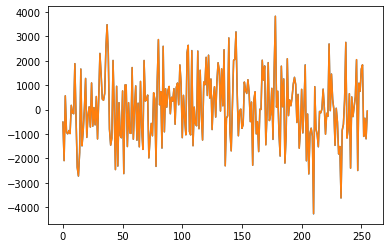

In [63]:
plt.plot(actual)
plt.plot(got)

In [36]:
out

tensor([[-0.0133]], grad_fn=<TanhBackward0>)